In [50]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [51]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [52]:
columns = ['PERMIT_ID', 'UNITS', 'NET_UNITS', 'BESTSTAT', 'YEAR', 'QUARTER', 'NAMEADDR', 'LOCATION']

def loadData():
    file_name = "data_complete/PipelineCleaned_"
    data = []
    for year in range(2013, 2018):
        for q in range(1, 5):
            if (year == 2017 and q == 3) or (year == 2013 and q < 4):
                break
            X = pd.read_csv(file_name + str(year) + "_Q" + str(q) + ".csv", sep=',', infer_datetime_format=True)
            X["YEAR"] = year
            X["QUARTER"] = q
            data.append(X)
    df = pd.concat(data)
    return df
   
def loadPermits():
    converters = {'Permit Number': lambda x: 'N'+x.replace(',','')}
    permits = pd.read_csv("data_complete/Building_Permits_Filtered.csv", sep=',', infer_datetime_format=True, parse_dates=['PERMIT_STATUS_DATE'])
    permits = permits[['PERMIT_ID', 'PERMIT_TYPE']]
    permits = permits[~permits.duplicated('PERMIT_ID')]
    permits = permits.set_index('PERMIT_ID')
    return permits

df = loadData()
df = df[columns]
future_df = df[(df["BESTSTAT"] != "CONSTRUCTION") & (df["YEAR"] == 2017)]
permits = loadPermits()
#future_df.groupby("BESTSTAT").count()
df = df[df["BESTSTAT"] == "CONSTRUCTION"]
df.drop(["BESTSTAT"], inplace=True, axis=1)
#df.head()

In [53]:
#df[df['PERMIT_ID'] == 'N200711077587']
not df[(df['YEAR'] == 2017) & (df['QUARTER'] == 2) & (df['PERMIT_ID'] == 'N200711077587')].empty

False

In [54]:
def fill_3_last_quarters(df):
    def has_entry(permit_id, year, quarter):
        is_present = not df[(df['YEAR'] == year) & (df['QUARTER'] == quarter) & (df['PERMIT_ID'] == permit_id)].empty
        return "in construction" if is_present else "not listed"
    df["2017Q2"] = df['PERMIT_ID'].apply(lambda x: has_entry(x, 2017, 2))
    df["2017Q1"] = df['PERMIT_ID'].apply(lambda x: has_entry(x, 2017, 1))
    df["2016Q4"] = df['PERMIT_ID'].apply(lambda x: has_entry(x, 2016, 4))
    return df
df = fill_3_last_quarters(df)

In [55]:
# keep only first and last entry for each building
construction_start = df.sort_values(['YEAR', 'QUARTER']).drop_duplicates(subset=['PERMIT_ID'], keep="first")
construction_end = df.sort_values(['YEAR', 'QUARTER']).drop_duplicates(subset=['PERMIT_ID'], keep="last")

data = pd.merge(construction_start[['PERMIT_ID', 'YEAR', 'QUARTER']], construction_end, 
                how='inner', on=['PERMIT_ID'], left_on=None, right_on=None, suffixes=('_START', '_END'))


data = data[~data.duplicated('PERMIT_ID')]
data = data.set_index('PERMIT_ID')
data = data[~data.duplicated('NAMEADDR')]

print(len(data))
data = data.join(permits, how='inner')
print(len(data))

# Duration = last 'construction' entry year/quarter - permit issue year/quarter in quarters
data['DURATION'] = (data['YEAR_END'] - data['YEAR_START']) * 4 + data['QUARTER_END'] - data['QUARTER_START'] + 1
data = data[['UNITS', 'NET_UNITS', 'YEAR_END', 'QUARTER_END', 'NAMEADDR', 'YEAR_START', 'QUARTER_START',
             'DURATION', 'LOCATION', 'PERMIT_TYPE', '2016Q4', '2017Q1', '2017Q2']]

print(data[data['NET_UNITS'] > 50].groupby('PERMIT_TYPE')['DURATION'].mean())

643
643
PERMIT_TYPE
additions alterations or repairs    3.875000
new construction                    5.061538
new construction wood frame         6.250000
Name: DURATION, dtype: float64


In [56]:
# Split completed by 2017Q1 and still in construction by 2017Q1
to_predict_ids = data[(data['YEAR_END'] == 2017) & (data['QUARTER_END'] == 2)].index
finished_ids = data[((data['YEAR_END'] == 2016) & (data['QUARTER_END'] == 4)) | 
                    ((data['YEAR_END'] == 2017) & (data['QUARTER_END'] == 1))].index

# finished in 2017Q1
finished = data[data.index.isin(finished_ids)]
# have determined finish date in the dataset
complete = data[~data.index.isin(to_predict_ids)]
# in construction by 2017Q1
incomplete = data[(data.index.isin(to_predict_ids)) & (~data.index.isin(finished_ids))]

# cut data that may have start date before the datasets start
complete = complete[(complete['YEAR_START'] != 2013) & (~((complete['YEAR_START'] == 2014) & (complete['QUARTER_START'] == 1)))]

print("Completed by 2017: ", complete['NET_UNITS'].count())
print("Still in construction by 2017: ", incomplete['NET_UNITS'].count())
finished.head()

Completed by 2017:  268
Still in construction by 2017:  218


,UNITS,NET_UNITS,YEAR_END,QUARTER_END,NAMEADDR,YEAR_START,QUARTER_START,DURATION,LOCATION,PERMIT_TYPE,2016Q4,2017Q1,2017Q2
PERMIT_ID,,,,,,,,,,,,,
N200711077587,1,1,2016,4,268 MADISON ST,2014,1,12,"(37.72572244670, -122.42280357600)",new construction wood frame,in construction,not listed,not listed
N200809252660,69,69,2016,4,1450 FRANKLIN ST,2014,1,12,"(37.78805629210, -122.42325307500)",new construction,in construction,not listed,not listed
N200810315629,1,1,2016,4,160 SAN MARCOS AV,2014,1,12,"(37.74709320810, -122.46511538900)",new construction wood frame,in construction,not listed,not listed
N200710155355,2,1,2016,4,1196 HAMPSHIRE ST,2014,1,12,"(37.75329796030, -122.40760652600)",additions alterations or repairs,in construction,not listed,not listed
N201010253666,3,3,2016,4,2034 CLEMENT ST,2014,1,12,"(37.78252401560, -122.48128426200)",new construction wood frame,in construction,not listed,not listed


In [57]:
columns = ['NAMEADDR', 'YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED', 'DURATION_PREDICTED', 'DURATION', 
           'UNITS', 'NET_UNITS', 'YEAR_END', 'QUARTER_END', 'YEAR_START', 'QUARTER_START', 'LOCATION', 
           'PERMIT_TYPE', '2016Q4', '2017Q1', '2017Q2']
    
# positives only
def add_quarters(df, quarter_num):
    df["QUARTER_END_PREDICTED"] = (finished["QUARTER_END"] + quarter_num) % 4
    df[df["QUARTER_END_PREDICTED"] == 0]["QUARTER_END_PREDICTED"] = 4
    df["YEAR_END_PREDICTED"] = df["YEAR_END"] + (finished["QUARTER_END"] + quarter_num - 1) / 4
    df[['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED']] = df[['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED']].astype('int64')
    
    return df

def add_prediction(permits, complete):
    # duration is estimated based on completed buildings with ~same net units number
    def predict_duration(duration, net_units):
        nearest_vals = complete[(complete['NET_UNITS'] > net_units * 0.7) & (complete['NET_UNITS'] < net_units * 1.5)]
        if nearest_vals.empty:
            nearest_vals = complete.ix[(complete['NET_UNITS']-net_units).abs().argsort()[:5]]
        est_duration = nearest_vals['DURATION'].mean()
        return np.ceil(max(duration, est_duration))
    
    permits['DURATION_PREDICTED'] = permits.apply(lambda row: predict_duration(row['DURATION'], row['NET_UNITS']), axis=1)
    permits['YEAR_END_PREDICTED'] = np.floor(permits['YEAR_START'] + 
                                             (permits['QUARTER_START'] + permits['DURATION_PREDICTED'] - 1) / 4 
                                            ).astype('int64')
    permits['QUARTER_END_PREDICTED'] = ((permits['QUARTER_START'] + permits['DURATION_PREDICTED']) % 4).astype('int64')
    permits['QUARTER_END_PREDICTED'][permits['QUARTER_END_PREDICTED'] == 0] = 4
    permits[['DURATION_PREDICTED', 'YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED']] = permits[['DURATION_PREDICTED', 'YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED']].astype('int64')
                                                    
    return permits[columns]

In [58]:
# Construction duration mean for medium-large buildings, check without alterations
print(complete[(complete['PERMIT_TYPE'] != "additions alterations or repairs") & (complete['NET_UNITS'] > 70)]['DURATION'].mean())
complete.sort_values(by="NET_UNITS", ascending=False).head(5)

5.782608695652174


,UNITS,NET_UNITS,YEAR_END,QUARTER_END,NAMEADDR,YEAR_START,QUARTER_START,DURATION,LOCATION,PERMIT_TYPE,2016Q4,2017Q1,2017Q2
PERMIT_ID,,,,,,,,,,,,,
N200605161774,452,452,2015,4,399 FREMONT ST,2014,3,6,"(37.78732243240, -122.39222370700)",new construction,not listed,not listed,not listed
N201304023626,409,409,2015,3,280 BEALE ST,2014,2,6,"(37.78870573880, -122.39360853700)",new construction,not listed,not listed,not listed
N201307303137,408,408,2016,4,350 08TH ST,2014,4,9,"(37.77369416570, -122.40965844000)",new construction wood frame,in construction,not listed,not listed
N201112070234,393,393,2016,1,1006 / 1050 16TH ST & 1380 07TH ST,2014,3,7,"(37.7666898720, -122.397182)",new construction,not listed,not listed,not listed
N201207124717,285,285,2016,1,201 FOLSOM ST,2014,2,8,"(37.7884130260, -122.391516)",new construction,not listed,not listed,not listed


In [59]:
#grouped = complete[complete['PERMIT_TYPE'] != "additions alterations or repairs"].sort_values(['NET_UNITS']).groupby(['NET_UNITS']).mean()
#grouped.plot(y = 'DURATION', kind = "bar", figsize=(20,10), title = "Duration mean by net units number")

In [60]:
# fill missing columns for finished in 2016Q4 buildings
finished = add_quarters(finished, 1)
finished["DURATION_PREDICTED"] = finished["DURATION"]
display(finished.head())

# predict durations for incomplete buildings
incomplete = add_prediction(incomplete, complete).sort_values(by="NET_UNITS", ascending=False)
display(incomplete.head(20))
result = finished.append(incomplete).sort_values(by="NET_UNITS", ascending=False)

result = result[result["YEAR_END_PREDICTED"] < 2019]

,UNITS,NET_UNITS,YEAR_END,QUARTER_END,NAMEADDR,YEAR_START,QUARTER_START,DURATION,LOCATION,PERMIT_TYPE,2016Q4,2017Q1,2017Q2,QUARTER_END_PREDICTED,YEAR_END_PREDICTED,DURATION_PREDICTED
PERMIT_ID,,,,,,,,,,,,,,,,
N200711077587,1,1,2016,4,268 MADISON ST,2014,1,12,"(37.72572244670, -122.42280357600)",new construction wood frame,in construction,not listed,not listed,1,2017,12
N200809252660,69,69,2016,4,1450 FRANKLIN ST,2014,1,12,"(37.78805629210, -122.42325307500)",new construction,in construction,not listed,not listed,1,2017,12
N200810315629,1,1,2016,4,160 SAN MARCOS AV,2014,1,12,"(37.74709320810, -122.46511538900)",new construction wood frame,in construction,not listed,not listed,1,2017,12
N200710155355,2,1,2016,4,1196 HAMPSHIRE ST,2014,1,12,"(37.75329796030, -122.40760652600)",additions alterations or repairs,in construction,not listed,not listed,1,2017,12
N201010253666,3,3,2016,4,2034 CLEMENT ST,2014,1,12,"(37.78252401560, -122.48128426200)",new construction wood frame,in construction,not listed,not listed,1,2017,12


,NAMEADDR,YEAR_END_PREDICTED,QUARTER_END_PREDICTED,DURATION_PREDICTED,DURATION,UNITS,NET_UNITS,YEAR_END,QUARTER_END,YEAR_START,QUARTER_START,LOCATION,PERMIT_TYPE,2016Q4,2017Q1,2017Q2
PERMIT_ID,,,,,,,,,,,,,,,,
N201412234418,TRANSBAY BLOCK 8,2019,1,7,1,546,546,2017,2,2017,2,"(37.7878990173, -122.3945922852)",new construction,not listed,not listed,in construction
N201503110506,TRANSBAY BLOCK 9,2019,1,7,1,545,545,2017,2,2017,2,"(37.7872047424, -122.3951034546)",new construction,not listed,not listed,in construction
N201209069080,TRINITY PLAZA,2017,3,9,9,540,540,2017,2,2015,2,"(37.7779273987, -122.4130172729)",new construction,in construction,in construction,in construction
N201309045886,801 BRANNAN ST,2017,3,9,9,434,434,2017,2,2015,2,"(37.7718238831, -122.4038848877)",new construction,in construction,in construction,in construction
N201406138394,150 VAN NESS AV,2018,3,7,3,431,431,2017,2,2016,4,"(37.7773017883, -122.418296814)",new construction,in construction,in construction,in construction
N201404304554,41 TEHAMA ST,2017,3,8,8,403,403,2017,2,2015,3,"(37.7869796753, -122.3966217041)",new construction,in construction,in construction,in construction
N201406259481,TRANSBAY BLOCK 1,2019,2,8,1,390,390,2017,2,2017,2,"(37.7897377014, -122.3917541504)",new construction,not listed,not listed,in construction
N201406259383,800 INDIANA ST,2018,2,8,5,326,326,2017,2,2016,2,"(37.7591972351, -122.3917312622)",new construction,in construction,in construction,in construction
N201408133775,MISSION BAY BLOCK 1 (RESIDENTIAL) 03RD,2017,3,6,6,198,198,2017,2,2016,1,"(37.7750511169, -122.3906402588)",new construction,in construction,in construction,in construction


To be completed in 2017: 4573 units, 191 buildings
To be completed in 2018: 2438 units, 117 buildings


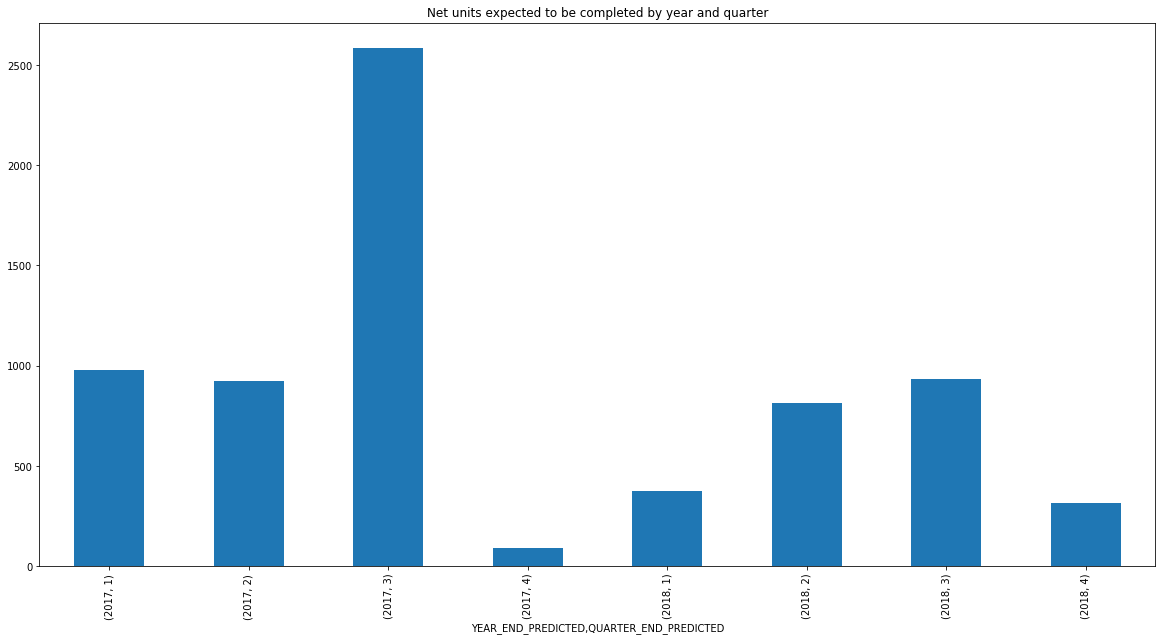

In [61]:
def plot_quarters(df):
    df.plot.bar(stacked=True, figsize=(20,10), title="Net units expected to be completed by year and quarter");
    
print("To be completed in 2017: {0} units, {1} buildings".format(
      result[result["YEAR_END_PREDICTED"] == 2017]["NET_UNITS"].sum(), 
      result[result["YEAR_END_PREDICTED"] == 2017]["NET_UNITS"].count()))

print("To be completed in 2018: {0} units, {1} buildings".format(
      result[result["YEAR_END_PREDICTED"] == 2018]["NET_UNITS"].sum(), 
      result[result["YEAR_END_PREDICTED"] == 2018]["NET_UNITS"].count()))

plot_quarters(result.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'])['NET_UNITS'].sum())

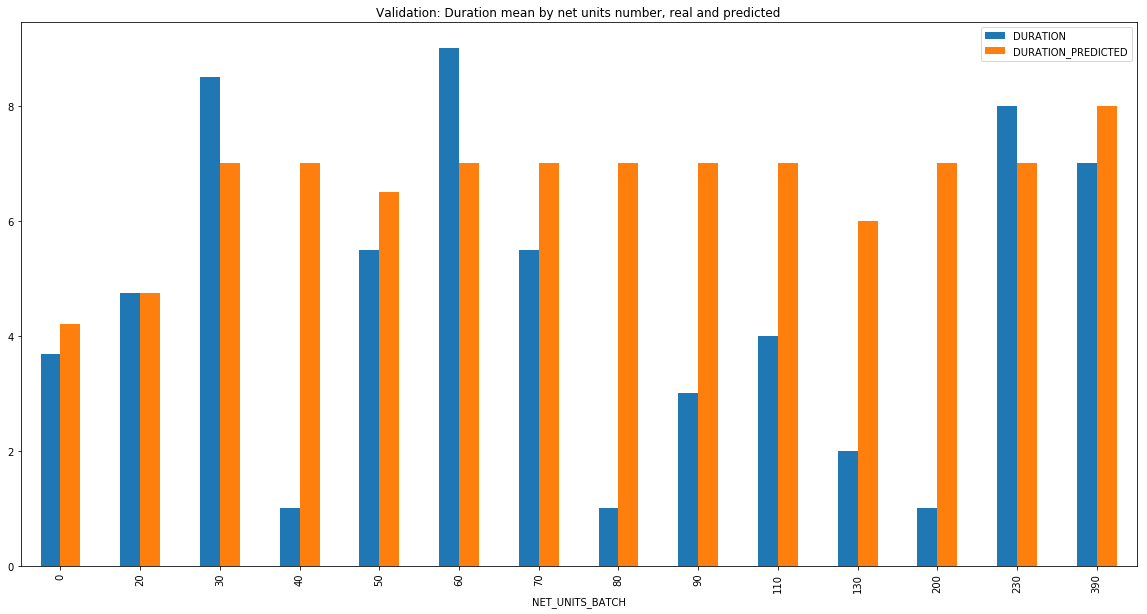

In [62]:
# Validation on piece of completed buildings data
train, validate = np.split(complete.sample(frac=1), [int(.7*len(complete))])
saved_duration = validate['DURATION'].copy()
validate['DURATION'] = 1

complete_validated = add_prediction(validate, train).sort_values(by="NET_UNITS", ascending=False)
complete_validated['DURATION'] = saved_duration
complete_validated['NET_UNITS_BATCH'] = (complete_validated['NET_UNITS'] / 10).astype('int64') * 10
complete_validated.groupby(by=["NET_UNITS_BATCH"])[['DURATION', 'DURATION_PREDICTED']].mean().plot.bar(figsize=(20,10), title="Validation: Duration mean by net units number, real and predicted");

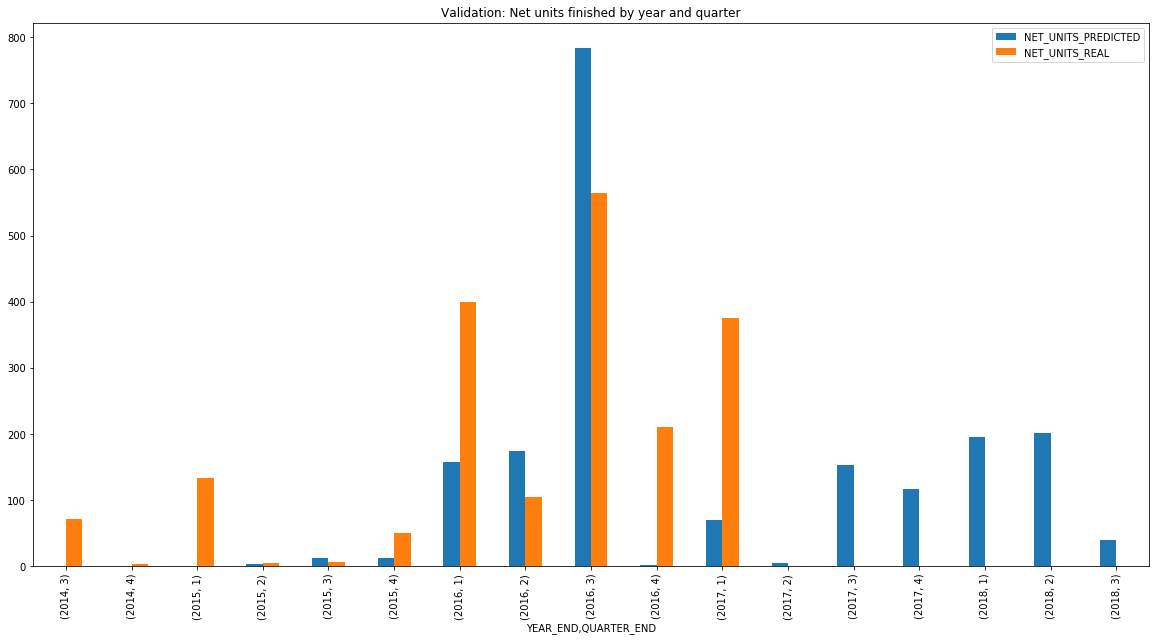

In [63]:
predicted = complete_validated.groupby(by=['YEAR_END_PREDICTED', 'QUARTER_END_PREDICTED'])['NET_UNITS'].sum().reset_index()
real = complete_validated.groupby(by=['YEAR_END', 'QUARTER_END'])['NET_UNITS'].sum().reset_index()
predicted = predicted.rename(columns={"YEAR_END_PREDICTED": "YEAR_END", "QUARTER_END_PREDICTED": "QUARTER_END"})

df_sum = pd.merge(predicted, real, how='outer', on=['YEAR_END', 'QUARTER_END'], 
                  left_on=None, right_on=None, suffixes=('_PREDICTED', '_REAL'))

df_sum.groupby(by=['YEAR_END', 'QUARTER_END']).sum().plot.bar(figsize=(20,10), title="Validation: Net units finished by year and quarter");

In [64]:
result[result["YEAR_END_PREDICTED"] == 2017].to_csv("housing_predictions/2017_prediction.csv", columns=columns)
result[result["YEAR_END_PREDICTED"] == 2018].to_csv("housing_predictions/2018_prediction.csv", columns=columns)

result.head(50).to_csv("housing_predictions/2017-2018_largest_products.csv", columns=columns)